In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [3]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import pandas as pd
import torch

In [4]:
attributes =['title','manufacturer','price']

## Hybrid

### Dataset creation

In [5]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/amazongoogle_hybrid.pth')
hybrid_model = hybrid_model.cuda()

In [6]:
negatives = return_layer_input(hybrid_model,hybrid_model.classifier,'../../datasets/Structured/Amazon-Google/'
                                                                         ,'negatives')

In [6]:
testneg = return_layer_input(hybrid_model,hybrid_model.classifier,'../../datasets/Structured/Amazon-Google/'
                                                                         ,'test_negatives')

In [10]:
positives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/Amazon-Google/','positives')

In [7]:
testpos = return_layer_input(hybrid_model,hybrid_model.classifier,'../../datasets/Structured/Amazon-Google/',
                                                                  'test_positives')

In [10]:
classifier_len = len(list(positives.values())[0])
attribute_len = int(classifier_len/len(attributes))

### Negatives analysis

In [11]:
negatives_ri_hybrid,neg_ri_norms_df = computeRi(hybrid_model.classifier,
                                                    attributes,testneg,0)

100%|██████████| 2059/2059 [01:32<00:00, 22.22it/s]


NameError: name 'negatives_ri' is not defined

In [12]:
torch.save(negatives_ri_hybrid,'experiment_results/testneg_ri_hybrid.pt')

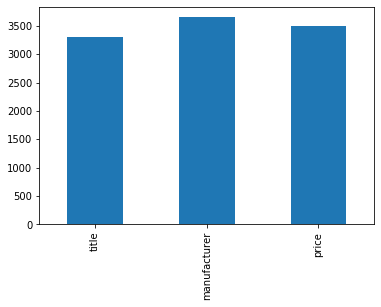

In [13]:
neg_ri_norms_df.sum().plot.bar()

In [20]:
def getRiNorms(ri,attributes):
    ri = ri.values()
    ri_norms = [[torch.norm(v).item() for v in ris] for ris in ri]
    ri_norms_df = pd.DataFrame(data=ri_norms,columns=attributes)
    return ri_norms_df

In [21]:
##save to file
neg_ri = torch.load('experiment_results/testneg_ri_hybrid.pt')
negatives_variation_df = getRiNorms(neg_ri,attributes)
negatives_variation_df.to_csv('experiment_results/testneg_ri_norms_hybrid.csv',index=False)

## Test positives analysis

In [16]:
positives_ri_hybrid,pos_ri_norms_hybrid = computeRi(hybrid_model.classifier,
                                                    attributes,testpos,1)
torch.save(positives_ri_hybrid,'experiment_results/testpos_ri_hybrid.pt')

100%|██████████| 234/234 [00:12<00:00, 19.44it/s]


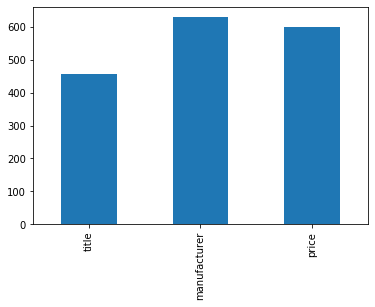

In [17]:
pos_ri_norms_hybrid.sum().plot.bar()

In [22]:
##save to file
pos_ri = torch.load('experiment_results/testpos_ri_hybrid.pt')
pos_ri_norms = getRiNorms(pos_ri,attributes)
pos_ri_norms.to_csv('experiment_results/testpos_ri_norms_hybrid.csv',index=False)

In [28]:
##Save results to file
positives_variation_df.to_csv('experiment_results/testpositives_ri_hybrid.csv',index=False)

## Compute nearest neighbours

In [55]:
from utils.distance_measures import nearestNeighborsOnAttribute

In [56]:
positives_nn_hybrid = nearestNeighbors(testpos_classifier_hybrid,testpos_ids_hybrid,
                                                               positives_ri_hybrid,
                                                       neg_classifier_hybrid,neg_ids_hybrid,
                                                               attributes,attribute_len_hybrid)

NameError: name 'calculate_nearest_neighbors_onAttributes' is not defined

In [34]:
negatives_nn_hybrid = calculate_nearest_neighbors_onAttributes(testneg_classifier_hybrid,testneg_ids_hybrid,
                                                              negatives_ri_hybrid,pos_classifier_hybrid,
                                                              pos_ids_hybrid,attributes,attribute_len_hybrid)

100%|██████████| 128/128 [00:00<00:00, 631.99it/s]


In [36]:
positives_nn_hybrid.to_csv('experiment_results/testpos_nn_hybrid.csv',index=False)
negatives_nn_hybrid.to_csv('experiment_results/testneg_nn_hybrid.csv',i)

NameError: name 'negatives_nn_' is not defined